In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from ast import literal_eval
import statsmodels.api as sm

- Introduction
- Genres
- Actors
    - Name
    - Genre
    - Nationalities? (need scraping)
- Awards
- Countries & Languages
    - Countries
    - Languages
- Plot summaries
- Conclusion

# Introduction

In [2]:
data = pd.read_csv('data/processed/cmu_movies_augmented.csv')

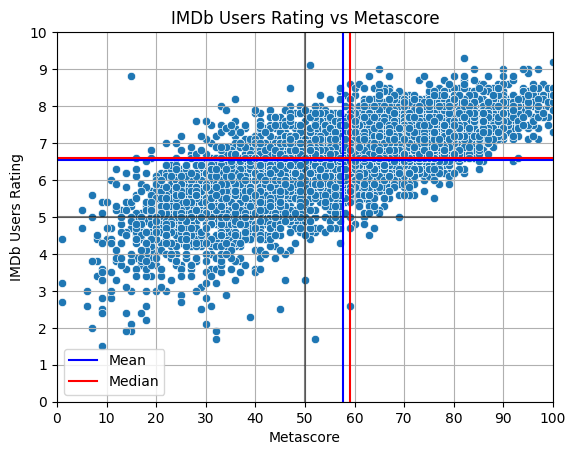

In [3]:
sns.scatterplot(x="metascore", y="imdb_rating", data=data)
plt.title("IMDb Users Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

# plot center lines
plt.axhline(y=5, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=50, color='k', linestyle='-', alpha=0.5)

# plot mean lines
plt.axhline(y=data['imdb_rating'].mean(), color='b', linestyle='-')
plt.axvline(x=data['metascore'].mean(), color='b', linestyle='-')

# plot median lines
plt.axhline(y=data['imdb_rating'].median(), color='r', linestyle='-')
plt.axvline(x=data['metascore'].median(), color='r', linestyle='-')

# legend the lines but not the scatter plots
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
plt.legend(handles=[blue_line, red_line])

plt.show()

In [4]:
data['imdb_rating_scaled'] = data['imdb_rating'] * 10
data['rating_difference'] = data['metascore'] - data['imdb_rating_scaled']

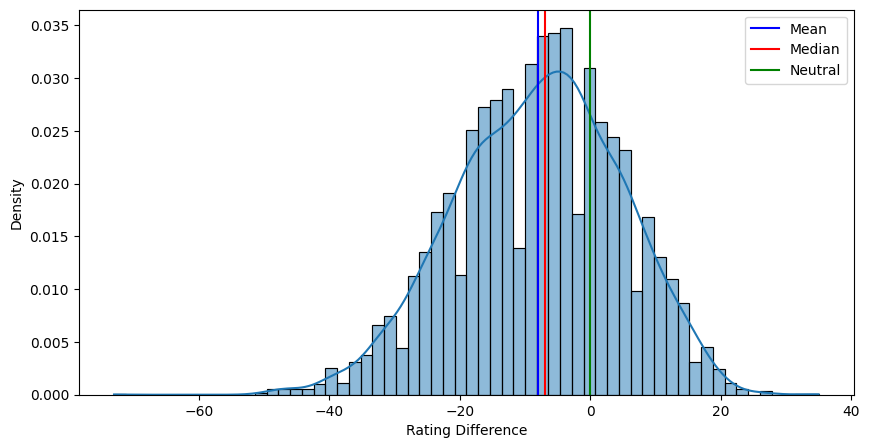

In [5]:
# Plot the mean and median and neutral rating difference
plt.figure(figsize=(10,5))
sns.histplot(data['rating_difference'], kde=True, stat='density', alpha=0.5)
plt.axvline(data['rating_difference'].mean(), color='b')
plt.axvline(data['rating_difference'].median(), color='r')
plt.axvline(0, color='g')
plt.xlabel('Rating Difference')
plt.ylabel('Density')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

## Genres

In [6]:
# Function to parse the genres column
def parse_genres(genres_str):
    try:
        genres_dict = literal_eval(genres_str)
        return list(genres_dict.values())
    except:
        return []

# Apply the function to the genres column
data['parsed_genres'] = data['genres'].apply(parse_genres)

# Explode the dataset so each genre gets its own row
exploded_genres = data.explode('parsed_genres')

# Group by genre and calculate average rating_difference for each genre
genre_scores = exploded_genres.groupby('parsed_genres')['rating_difference'].mean().reset_index()

# Dropping rows where genre is NaN or Metascore is NaN
genre_scores = genre_scores.dropna()

# Sorting the genres by average rating_difference
genre_scores_sorted = genre_scores.sort_values(by='rating_difference', ascending=False)

# Display the top 10 genres
top_genres = genre_scores_sorted.head(10)
display(top_genres)

# Display the bottom 10 genres
flop_genres = genre_scores_sorted.tail(10)
display(flop_genres)

,parsed_genres,rating_difference
142,Foreign legion,18.000000
285,Star vehicle,16.000000
230,Point of view shot,16.000000
53,Cavalry Film,15.000000
47,British New Wave,15.000000
106,Ealing Comedies,15.000000
271,Silent film,14.545455
241,Propaganda film,9.333333
189,Kitchen sink realism,9.000000
40,Black-and-white,7.275862


,parsed_genres,rating_difference
297,Sword and sorcery,-18.538462
177,Indian Western,-18.666667
296,Sword and Sandal,-19.500000
179,Inspirational Drama,-19.733333
156,Gross-out film,-20.682927
155,Gross out,-20.682927
26,Archaeology,-21.000000
195,Live action,-25.500000
310,Werewolf fiction,-28.000000
220,Ninja movie,-29.000000


### Pearson Correlation

In [7]:
hotencoded_movies_genres = exploded_genres.copy()

# Assuming you have a DataFrame 'exploded_genres'
hotencoded_movies_genres = pd.get_dummies(hotencoded_movies_genres, columns=['parsed_genres'], prefix='onehot')

# Drop rows with missing values in the 'rating_difference' column
hotencoded_movies_genres = hotencoded_movies_genres.dropna(subset=['rating_difference'])

hotencoded_genres_columns = list(filter(lambda x: x.startswith('onehot'), hotencoded_movies_genres.columns))

# Dictionary to store results
correlation_results = {}

# Calculate correlation and p-value for each genre
for col in hotencoded_genres_columns:
    correlation, p_value = pearsonr(hotencoded_movies_genres[col], hotencoded_movies_genres['rating_difference'])
    if not np.isnan(correlation):
        correlation_results[col] = {'correlation': correlation, 'p_value': p_value}

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(correlation_results, orient='index').sort_values(by='correlation', ascending=False)
display(results_df.head(10))
display(results_df.tail(10))


/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,correlation,p_value
onehot_Black-and-white,0.072335,5.951511e-48
onehot_World cinema,0.068733,1.863614e-43
onehot_Drama,0.048222,3.268082e-22
onehot_Art film,0.041031,1.647286e-16
onehot_Film noir,0.033355,2.059786e-11
onehot_New Hollywood,0.032045,1.207552e-10
onehot_Documentary,0.031278,3.295881e-10
onehot_Silent film,0.029439,3.326802e-09
onehot_Biography,0.029031,5.456570e-09
onehot_History,0.027130,5.024387e-08


,correlation,p_value
onehot_Gross-out film,-0.032514,6.459758e-11
onehot_Gross out,-0.032514,6.459758e-11
onehot_Comedy,-0.036683,1.695692e-13
onehot_Horror,-0.036954,1.124715e-13
onehot_Slasher,-0.037697,3.595927e-14
onehot_Thriller,-0.038340,1.317963e-14
onehot_Teen,-0.039775,1.320548e-15
onehot_Slapstick,-0.043711,1.574514e-18
onehot_Action/Adventure,-0.050094,7.611638e-24
onehot_Action,-0.060246,9.069420e-34


### OLS

In [8]:
# Define the independent variables (X) and the dependent variable (y)
X = hotencoded_movies_genres[hotencoded_genres_columns]  # Add all your genre columns here
y = hotencoded_movies_genres['rating_difference']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     8.188
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:26:39   Log-Likelihood:            -1.5814e+05
No. Observations:               40350   AIC:                         3.169e+05
Df Residuals:                   40035   BIC:                         3.196e+05
Df Model:                         314                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [9]:
# Find the genres with p-values less than 0.05
significant_genres = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        significant_genres.append([row[0], float(row[1]), float(row[4])])

# Convert the list of significant genres to a DataFrame
significant_genres_df = pd.DataFrame(significant_genres, columns=['genre', 'coef', 'p_value'])
significant_genres_df = significant_genres_df.sort_values(by='coef', ascending=False)
display(significant_genres_df)

,genre,coef,p_value
10,onehot_Foreign legion,27.8182,0.029
23,onehot_Star vehicle,25.8182,0.006
18,onehot_Point of view shot,25.8182,0.043
3,onehot_British New Wave,24.8182,0.008
22,onehot_Silent film,24.3636,0.000
20,onehot_Propaganda film,19.1515,0.016
1,onehot_Black-and-white,17.0940,0.000
16,onehot_Mumblecore,16.4848,0.003
21,onehot_Samurai cinema,15.0182,0.005
5,onehot_Essay Film,14.6753,0.013


## Actors

In [156]:
characters_data = pd.read_csv('data/preprocessed/character.metadata.preprocessed.tsv', sep='\t')

In [158]:
# Filter out movies that are not in the movies dataset
characters_data = characters_data[characters_data['wikipedia_id'].isin(data.loc[~data['rating_difference'].isna(),'wikipedia_id'])]

In [162]:
# Keep actors that have at least 10 movies
actor_counts = characters_data['freebase_actor_id'].value_counts()
actors_to_keep = actor_counts[actor_counts >= 10].index
characters_data_top_actors = characters_data[characters_data['freebase_actor_id'].isin(actors_to_keep)]

In [167]:
# Hot encode the actor freebase id column 
hotencoded_characters_data = pd.get_dummies(characters_data_top_actors, columns=['freebase_actor_id'], prefix='onehot')

hotencoded_columns = list(filter(lambda x: x.startswith('onehot'), hotencoded_characters_data.columns))

In [168]:
# Group by movie
grouped_by_movie = hotencoded_characters_data.groupby('wikipedia_id')[hotencoded_columns].sum()

In [171]:
# Merge with the movies dataset
merged_data = pd.merge(data[['rating_difference', 'metascore', 'imdb_rating', 'wikipedia_id']], grouped_by_movie, left_on='wikipedia_id', right_on='wikipedia_id', how='left')

In [173]:
# Drop rows with missing values in the hotencoded columns
merged_data = merged_data.dropna(subset=hotencoded_columns)

In [175]:
# Define the independent variables (X) and the dependent variable (y)
X = merged_data[hotencoded_columns]
y = merged_data['rating_difference']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     1.552
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.19e-27
Time:                        02:47:33   Log-Likelihood:                -20634.
No. Observations:                5582   AIC:                         4.451e+04
Df Residuals:                    3963   BIC:                         5.524e+04
Df Model:                        1618                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -9.0652      0.36

In [188]:
# Print the highest and lowest coefficients sorted
significant_actors = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        actor_id = row[0].split('_')[1]
        significant_actors.append([actor_id, float(row[1]), float(row[4])])

# Convert the list of significant actors to a DataFrame
significant_actors_df = pd.DataFrame(significant_actors, columns=['freebase_actor_id', 'coef', 'p_value'])

significant_actors_df = pd.merge(significant_actors_df, characters_data[['freebase_actor_id', 'actor_name']].drop_duplicates(), left_on='freebase_actor_id', right_on='freebase_actor_id', how='left')

significant_actors_df = significant_actors_df.sort_values(by='coef', ascending=False)

# Merge with the characters dataset to get the actor names

display(significant_actors_df.head(20))
display(significant_actors_df.tail(20))

,freebase_actor_id,coef,p_value,actor_name
72,/m/04,16.3939,0.000,NaN
86,/m/06hhrs,14.4668,0.001,Richard Kind
125,/m/0p8r1,14.2618,0.000,John Ratzenberger
84,/m/0668qk,13.2798,0.001,Olivier Gourmet
38,/m/02hfsd,12.8353,0.001,Ward Bond
27,/m/021t8p,11.8862,0.002,Michel Piccoli
112,/m/0cbkc,11.7755,0.000,Catherine Deneuve
74,/m/04sry,11.7384,0.002,Martin Scorsese
64,/m/04264n,11.6829,0.002,Keenan Wynn
17,/m/01mvth,11.4419,0.048,Jerry Nelson


,freebase_actor_id,coef,p_value,actor_name
119,/m/0dwz5n,-9.4871,0.024,Frank Grillo
115,/m/0czv3f,-9.4916,0.018,Oscar Isaac
60,/m/03s2dj,-9.5406,0.008,Callum Keith Rennie
78,/m/04z542,-9.5807,0.011,Michael Lerner
50,/m/03811k,-9.5867,0.016,Bridget Moynahan
83,/m/05qh0j,-9.6456,0.035,Kevin Heffernan
42,/m/02nrdp,-9.6666,0.021,Dom DeLuise
96,/m/07vljr,-10.1628,0.027,Allen Garfield
88,/m/06rq2l,-10.3349,0.039,Allen Covert
108,/m/0bs6hr,-10.5511,0.007,Norman Reedus


In [189]:
# List movies of an actor
def list_movies_of_actor(actor_id):
    movies_ids = characters_data[characters_data['freebase_actor_id'] == actor_id]['wikipedia_id'].unique()
    return data[data['wikipedia_id'].isin(movies_ids)]

In [193]:
list_movies_of_actor('/m/06t3nj').head(10)

,wikipedia_id,freebase_id,name,revenue,runtime,languages,countries,genres,release_date_datetime,imdb_id,metacritic_id,imdb_rating,imdb_votes,metascore,count_nomination,count_award,imdb_rating_scaled,rating_difference
1616,3210646,/m/08zjv6,Breakfast of Champions,178278.0,109.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01hwc6"": ""Absurdism"", ""/m/01t_vv"": ""Comed...",1999-09-17,tt0120618,movie/breakfast-of-champions,4.5,8189.0,42.0,0,0,45.0,-3.0
2849,3636498,/m/09rfh9,Saw III,164800000.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",2006-10-26,tt0489270,movie/saw-iii,6.2,208182.0,48.0,9,1,62.0,-14.0
3432,32092686,/m/0gw_7xk,Jayne Mansfield's Car,NaN,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama""}",2012-02-13,tt1781840,movie/jayne-mansfields-car,6.2,3397.0,48.0,0,0,62.0,-14.0
3738,1068520,/m/0435vm,The Island,162949164.0,138.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2005-07-11,tt0399201,movie/the-island,6.8,324099.0,50.0,6,1,68.0,-18.0
4065,1640736,/m/05jwph,Saw II,147700000.0,88.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",2005-10-28,tt0432348,movie/saw-ii,6.6,271280.0,40.0,11,4,66.0,-26.0
4630,9793561,/m/02pscpb,A Slipping-Down Life,107099.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0219x_"": ""Indie"", ""/m/03p5xs"": ""Comedy of...",1999-01-01,tt0162662,movie/a-slipping-down-life,6.1,1148.0,44.0,2,2,61.0,-17.0
4668,19844891,/m/05qbdb8,Saw VI,68200000.0,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",2009-10-22,tt1233227,movie/saw-vi,6.0,122230.0,30.0,2,0,60.0,-30.0
4999,1025150,/m/0fq7dv_,Saw,103000000.0,103.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",2004-01-19,tt0387564,movie/saw,7.6,456759.0,46.0,10,9,76.0,-30.0
5690,967721,/m/03v6q4,Summer School,35658098.0,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/01z4y"": ""Comedy"", ""/m...",1987-07-22,tt0094072,movie/summer-school,6.6,21659.0,27.0,0,0,66.0,-39.0
6551,7694669,/m/02pcq92,Saw IV,139352633.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",2007-10-25,tt0890870,movie/saw-iv,5.9,161632.0,36.0,7,2,59.0,-23.0


## Runtime

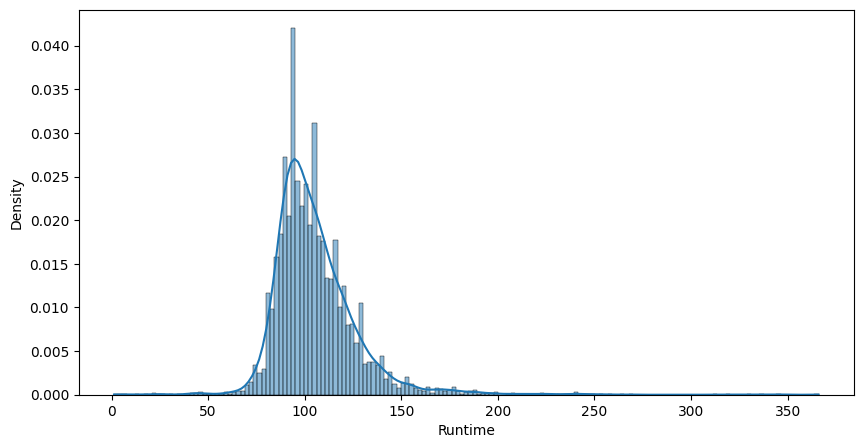

In [37]:
# Plot distribution of runtime
plt.figure(figsize=(10,5))
sns.histplot(data['runtime'], kde=True, stat='density', alpha=0.5)
plt.xlabel('Runtime')
plt.ylabel('Density')
plt.show()

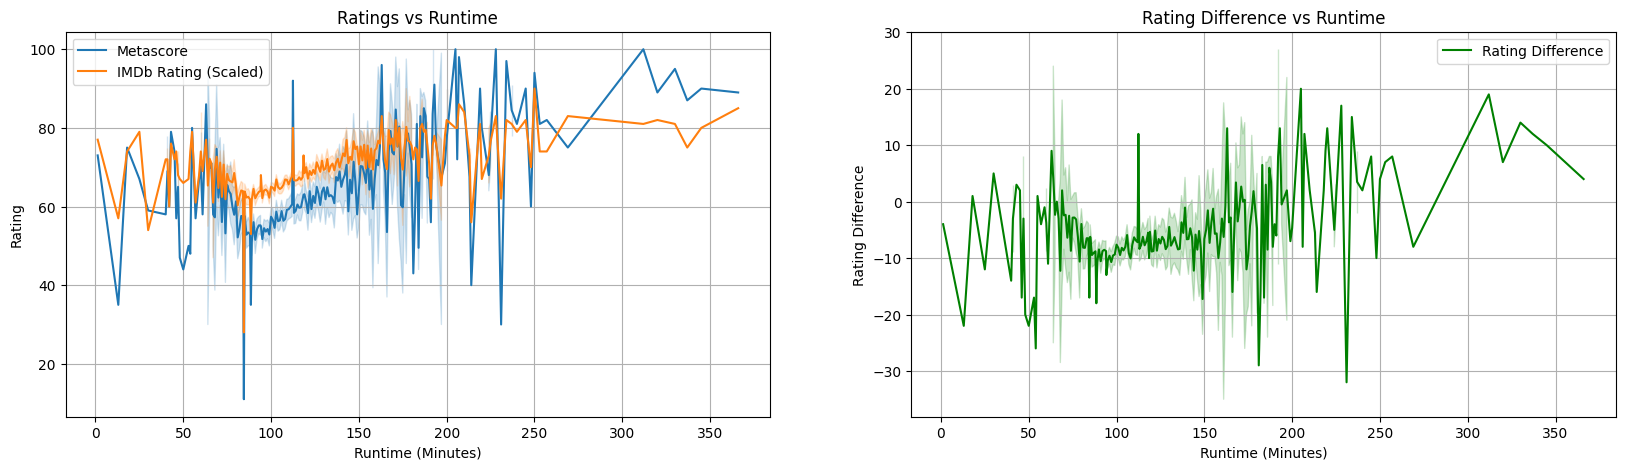

In [34]:
# Plot the distribution of rating difference per runtime
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="runtime", y="metascore", data=data_date, label='Metascore', ax=ax[0])
sns.lineplot(x="runtime", y="imdb_rating_scaled", data=data_date, label='IMDb Rating (Scaled)', ax=ax[0])

sns.lineplot(x="runtime", y="rating_difference", data=data_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Runtime")
ax[0].set_xlabel("Runtime (Minutes)")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Runtime")
ax[1].set_xlabel("Runtime (Minutes)")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

The plot shows a noisy relationship between rating difference and runtime, with no clear pattern. The data points are widely spread out, indicating a lot of variability in the rating differences for movies of similar lengths.

In [198]:
# Fit a linear regression model
filtered_data = data.dropna(subset=['runtime', 'rating_difference'])
X = filtered_data['runtime']
y = filtered_data['rating_difference']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     45.54
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.61e-11
Time:                        02:58:32   Log-Likelihood:                -29623.
No. Observations:                7493   AIC:                         5.925e+04
Df Residuals:                    7491   BIC:                         5.926e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7768      0.740    -17.271      0.0

- The R-squared value is 0.006, which means that only 0.6% of the variance in the rating difference is explained by the runtime. This indicates a very weak linear relationship between runtime and rating difference.
  
- The constant (intercept) coefficient is -12.7768 with a p-value close to 0, suggesting that the intercept is significantly different from 0. However, given that runtime cannot be 0, the practical interpretation of the intercept is limited.
  
- The runtime coefficient is 0.0463, indicating that for every additional minute of runtime, the rating difference increases by 0.0463 on average. While this is statistically significant (p-value < 0.001), the effect size is very small.

## Release date

In [5]:
data_date = data.copy()
data_date['release_date_datetime'] = pd.to_datetime(data_date['release_date_datetime'])
data_date['year'] = data_date['release_date_datetime'].dt.year
data_date['month'] = data_date['release_date_datetime'].dt.month
data_date = data_date.dropna(subset=['year', 'month', 'rating_difference'])

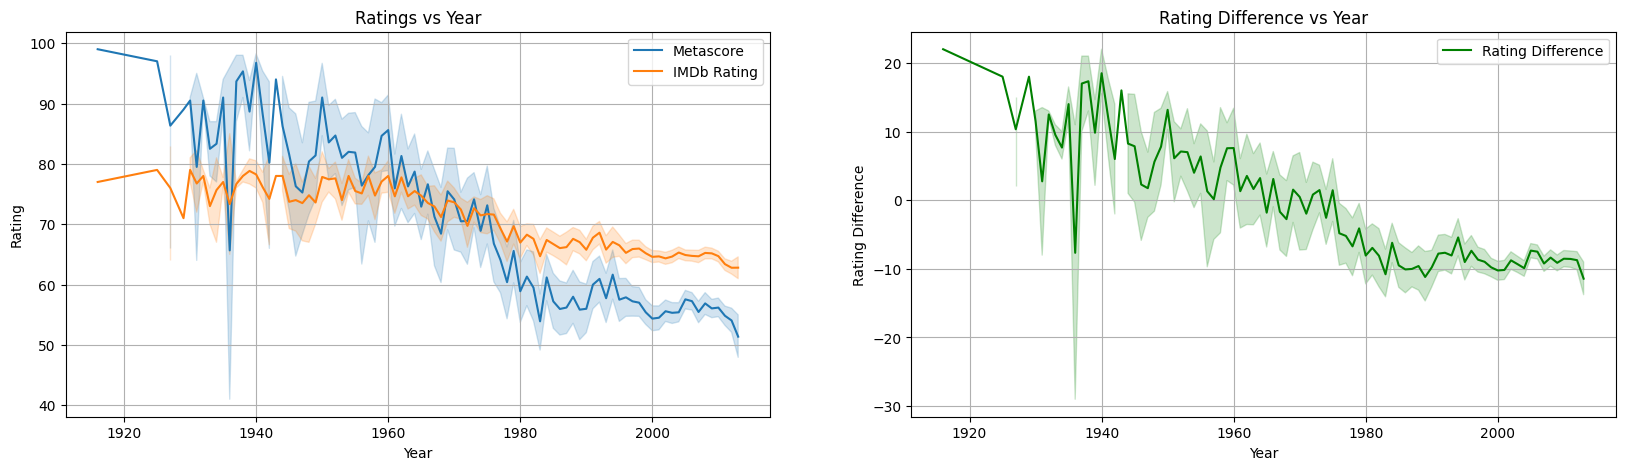

In [30]:
# Plot the distribution of rating difference per year
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="year", y="metascore", data=data_date, label='Metascore', ax=ax[0])
sns.lineplot(x="year", y="imdb_rating_scaled", data=data_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="year", y="rating_difference", data=data_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Year")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The first set of plots shows that both the Metascore and IMDb rating have a general downward trend over the years. This could suggest that either movies are getting worse, or perhaps more likely, that scoring criteria have become stricter over time.

- The plot for rating differences over the years indicates that the gap between Metascore and IMDb ratings has generally been widening. Early in the data, Metascore ratings are higher than IMDb, and over time, this trend reverses.

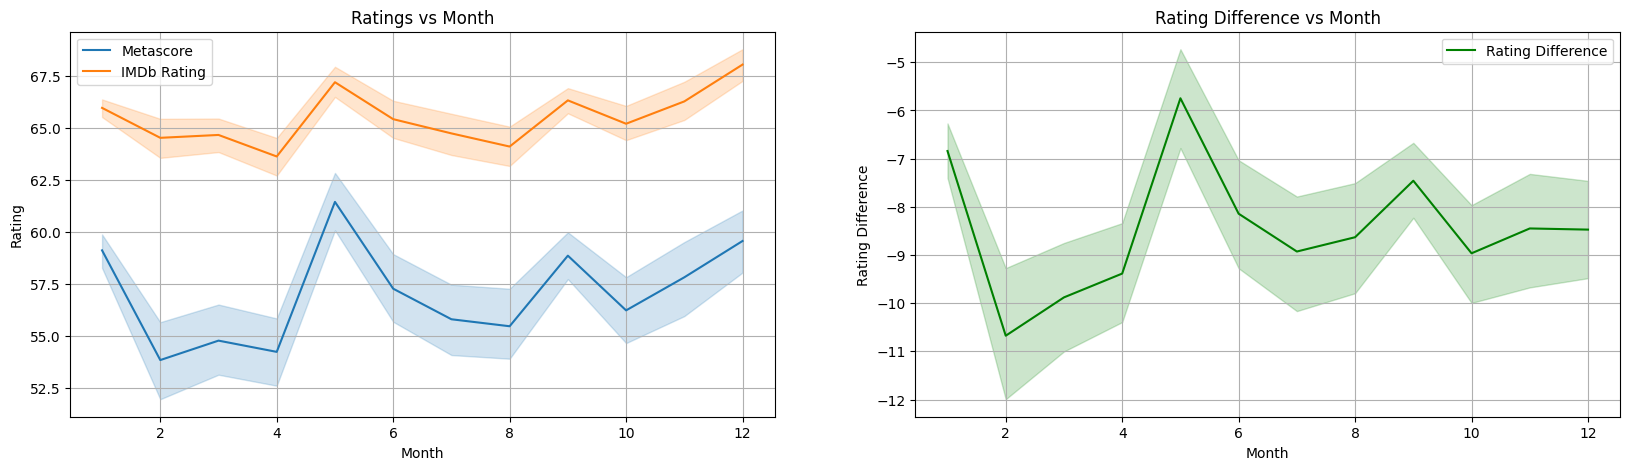

In [31]:
# Plot the distribution of rating difference per month
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="month", y="metascore", data=data_date, label='Metascore', ax=ax[0])
sns.lineplot(x="month", y="imdb_rating_scaled", data=data_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="month", y="rating_difference", data=data_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Month")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The monthly plots indicate some seasonality in ratings, with certain months having higher or lower average ratings. This could be due to the type of movies typically released in those months (e.g., Oscar-bait films in December).

- The monthly rating difference plot shows that the discrepancy between the two rating sources also varies by month, with some months showing a larger gap than others.

In [32]:
# Fit a linear regression model
X = data_date[['year', 'month']]
y = data_date['rating_difference']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     166.5
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.65e-71
Time:                        03:21:39   Log-Likelihood:                -30330.
No. Observations:                7702   AIC:                         6.067e+04
Df Residuals:                    7699   BIC:                         6.069e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.4519     21.250     17.762      0.0

- The model suggests that both year and month are significant predictors of the rating difference.

- The coefficient for year is -0.1925, indicating that with each passing year, the rating difference decreases by 0.1925 points. Given the R-squared value of 0.041, we know that year and month together explain about 4.1% of the variance in rating difference, which is not a lot, but it is significant.

- The coefficient for month is -0.0953, suggesting a smaller but still significant monthly effect on rating differences.

## Countries

In [62]:
data_countries['parsed_countries'][0]

['United States of America']

In [96]:
# Parse the countries column
def parse_countries(countries_str):
    try:
        countries_dict = literal_eval(countries_str)
        return list(countries_dict.values())
    except:
        return None

data_countries = data.copy()

# Apply the function to the countries column
data_countries['parsed_countries'] = data_countries['countries'].apply(parse_countries)

data_countries = data_countries.dropna(subset=['countries', 'rating_difference'])

# Explode the dataset so each (country, movie) gets its own row
data_countries = data_countries.explode('parsed_countries')

# Hot encode countries per movie
hotencoded_countries = data_countries.copy()
hotencoded_countries = pd.get_dummies(hotencoded_countries, columns=['parsed_countries'], prefix='onehot')

hotencoded_countries_columns = list(filter(lambda x: x.startswith('onehot'), hotencoded_countries.columns))

# Group by movie
grouped_by_movie = hotencoded_countries.groupby('wikipedia_id')[hotencoded_countries_columns].sum().reset_index()

hotencoded_countries = pd.merge(grouped_by_movie, data_countries[['wikipedia_id', 'rating_difference', 'metascore', 'imdb_rating_scaled']], on='wikipedia_id', how='left')

In [101]:
# Fit a linear regression model
X = hotencoded_countries[hotencoded_countries_columns]
y = hotencoded_countries['rating_difference']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     12.19
Date:                Sat, 09 Dec 2023   Prob (F-statistic):          6.52e-204
Time:                        03:50:03   Log-Likelihood:                -45074.
No. Observations:               11569   AIC:                         9.038e+04
Df Residuals:                   11454   BIC:                         9.122e+04
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

- The Adjusted R-squared value is 0.099, meaning that roughly 9.9% of the variance in the rating difference can be explained by the model. This is a significant improvement from previous models you mentioned, but still suggests that there are other factors not included in the model that influence the rating difference.

In [104]:
# Print the highest and lowest coefficients sorted
significant_countries = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        country = row[0].split('_')[1]
        significant_countries.append([country, float(row[1]), float(row[4])])

# Convert the list of significant countries to a DataFrame
significant_countries_df = pd.DataFrame(significant_countries, columns=['country', 'coef', 'p_value'])
significant_countries_df = significant_countries_df.sort_values(by='coef', ascending=False)
display(significant_countries_df.head(20))
display(significant_countries_df.tail(20))

,country,coef,p_value
35,Serbia and Montenegro,29.5768,0.000
0,Albania,21.0608,0.001
44,Weimar Republic,19.7990,0.001
4,Bahamas,15.1371,0.006
28,Panama,13.0024,0.031
22,Lithuania,12.5008,0.006
36,Slovak Republic,11.9341,0.013
6,Cameroon,11.3928,0.031
21,Kuwait,10.7567,0.048
37,Soviet Union,10.2146,0.009


,country,coef,p_value
14,Germany,-1.9558,0.000
2,Argentina,-2.2334,0.039
25,Netherlands,-2.4386,0.003
7,Canada,-2.5657,0.000
23,Luxembourg,-2.7825,0.022
9,Czech Republic,-3.7378,0.002
16,India,-3.8242,0.000
20,Kingdom of Great Britain,-5.4617,0.041
43,United States of America,-5.7336,0.000
33,Romania,-6.0635,0.000


- The countries with positive coefficients (like Albania, Bahamas) suggest that movies associated with these countries tend to have a higher Metascore compared to IMDb rating.

- Conversely, countries with negative coefficients (like Denmark, Bulgaria) suggest that movies associated with these countries tend to have a lower Metascore compared to IMDb rating.

- The p_value indicates the statistical significance of these coefficients. For example, countries like Serbia and Montenegro, Albania, and the Weimar Republic have coefficients that are statistically significant (p < 0.05), meaning we can be confident that these are not due to random chance.

It's important to note that correlation does not imply causation. The coefficients must also be interpreted with caution, especially for countries with a small number of movies represented in the dataset, as the estimates may be less reliable.

## Plot summaries

In [73]:
import nltk
from textblob import TextBlob
import textstat
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Ensure you have the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def extract_features(plot):

    text = plot['plot_summary']
    # Text Preprocessing
    tokens = word_tokenize(plot_summary.lower())  # Tokenization and lowercasing
    filtered_words = [word for word in tokens if word not in stopwords.words('english')]  # Stopword removal

    # Sentiment Analysis
    blob = TextBlob(plot_summary)
    sentiment = blob.sentiment  # Returns polarity and subjectivity

    # Text Complexity Measures
    flesch_reading_ease = textstat.flesch_reading_ease(plot_summary)  # Flesch Reading Ease Score

    return {
        "num_tokens": len(tokens),
        "num_unique_words": len(set(filtered_words)),
        "sentiment_polarity": sentiment.polarity,
        "sentiment_subjectivity": sentiment.subjectivity,
        "flesch_reading_ease": flesch_reading_ease,
        "wikipedia_id": plot['wikipedia_id']
    }

def process_dataset(df):
    # Open the dataset file
    features = []
    for plot in tqdm(df.to_dict('records')):

        # Extract features
        features.append(extract_features(plot))

    return pd.DataFrame(features)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
summaries = pd.read_csv('data/preprocessed/plot_summaries.preprocessed.txt')
summaries = summaries.loc[summaries['wikipedia_id'].isin(data.loc[~data['rating_difference'].isna(),'wikipedia_id'])]
summaries = pd.merge(summaries, data[['wikipedia_id', 'metascore', 'imdb_rating_scaled', 'rating_difference']], on='wikipedia_id')

In [64]:
processed_summaries = process_dataset(summaries)

100%|██████████| 7015/7015 [11:09<00:00, 10.48it/s]


In [74]:
processed_summaries_filtered = pd.merge(processed_summaries, data[['wikipedia_id', 'metascore', 'imdb_rating_scaled', 'rating_difference']], on='wikipedia_id')
processed_summaries_filtered.dropna(subset=['rating_difference'], inplace=True)

c:\Users\anton\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\anton\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


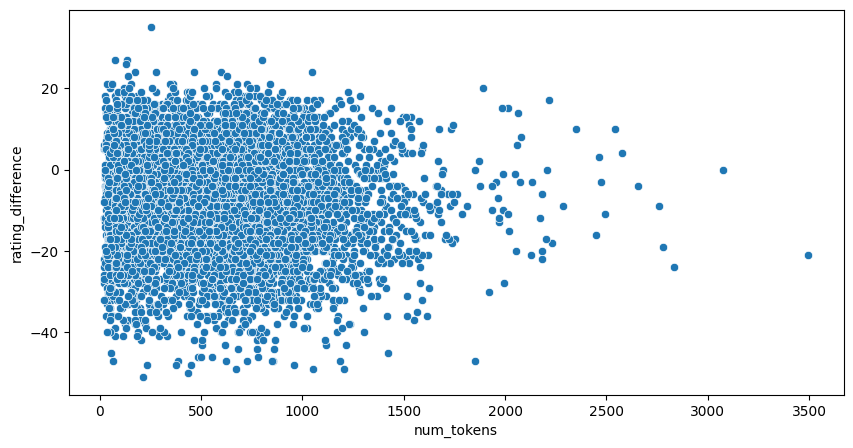

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.scatterplot(data=processed_summaries_filtered, x='num_tokens', y='rating_difference')
plt.show()


In [122]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
import gzip


def process_xml(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Initialize a list to store DataFrames
    dfs = []

    # Iterate through the XML elements and create a DataFrame for each sentence
    for sentence in root.findall('.//sentence'):
        sentence_data = {}
        tokens = []
        for token in sentence.findall('.//token'):
            tokens.append((token.find('word').text, token.find('NER').text))

        sentence_data['tokens'] = tokens

        # Extract basic-dependencies and collapsed-dependencies data and add them to the sentence_data dictionary
        for dep_type in ['basic-dependencies', 'collapsed-dependencies']:
            dep_data = []
            for dep in sentence.findall(f'.//{dep_type}/dep'):
                dep_type_attr = dep.get('type')
                governor = dep.find('governor').text
                dependent = dep.find('dependent').text
                dep_data.append({'type': dep_type_attr, 'dependent': dependent, 'governor': governor})

            sentence_data[dep_type] = dep_data

        df = pd.DataFrame([sentence_data])  # Create a DataFrame for the sentence
        dfs.append(df)  # Append the DataFrame to the list

    return dfs

In [101]:
def extract_entities(plot_parsed):
    entities = []
    for sentence in plot_parsed:
        for token in sentence['tokens'][0]:
            if token[1] != 'O':
                if token[0] not in entities:
                    entities.append(token[0])

    return entities

In [124]:
summaries_entities = []


for summary in tqdm(summaries.to_dict('records')):
    wikipedia_id = summary['wikipedia_id']

    # Check if the file exists
    filepath = f'data/raw/nlp_summaries/{wikipedia_id}.xml.gz'
    if not os.path.exists(filepath):
        continue

    file = gzip.open(filepath, 'r')
    
    parsed_plot = process_xml(file)

    entities = extract_entities(parsed_plot)

    summaries_entities.append({
        'wikipedia_id': wikipedia_id,
        'entities': entities
    })

summaries_entities_df = pd.DataFrame(summaries_entities)

100%|██████████| 6465/6465 [06:11<00:00, 17.42it/s]
